In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.mixture import GaussianMixture 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

y.replace("<=50K.", "<=50K", inplace=True)
y.replace(">50K.", ">50K", inplace=True)

/tmp/ipykernel_210/3320725914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace("<=50K.", "<=50K", inplace=True)
/tmp/ipykernel_210/3320725914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace(">50K.", ">50K", inplace=True)


In [3]:
y.value_counts()

income
<=50K     37155
>50K      11687
Name: count, dtype: int64

In [4]:
# Group the original dataset for how it was 
full_data = pd.concat([X,y], axis = 1)

# Breaking up the groups so can  do undersampling for greather than group
less_than = full_data[full_data["income"]=="<=50K"]
greater_than = full_data[full_data["income"]==">50K"]

# Conducting Undersampling Here 
greater_than_count = greater_than.shape[0]
less_than_under = less_than.sample(greater_than_count)


under_sampled_data = pd.concat([greater_than, less_than_under], axis=0)
under_sampled_data["lower_income_bool"] = under_sampled_data["income"] == "<=50K"

y = under_sampled_data["lower_income_bool"]
X = under_sampled_data.drop(columns=["income", "lower_income_bool"])

In [5]:
X = pd.get_dummies(X, drop_first=True)
# standardizing features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

gmm = GaussianMixture(n_components = 2)

gmm.fit(X_train)

y_pred = gmm.predict(X_test)

mapped_y_pred = [0 if label == y_test.mode()[0] else 1 for label in y_pred]

In [6]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7475935828877005
              precision    recall  f1-score   support

       False       0.70      0.85      0.77      2320
        True       0.82      0.64      0.72      2355

    accuracy                           0.75      4675
   macro avg       0.76      0.75      0.75      4675
weighted avg       0.76      0.75      0.74      4675



In [7]:
print("Accuracy:", accuracy_score(y_test, mapped_y_pred))
print("Classification Report:\n", classification_report(y_test, mapped_y_pred))

Accuracy: 0.25240641711229944
Classification Report:
               precision    recall  f1-score   support

       False       0.18      0.15      0.16      2320
        True       0.30      0.36      0.32      2355

    accuracy                           0.25      4675
   macro avg       0.24      0.25      0.24      4675
weighted avg       0.24      0.25      0.24      4675



In [8]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [9]:
y_test

9378     False
45566     True
44908    False
30769    False
45466     True
         ...  
5196     False
31878    False
19808     True
29803    False
43796    False
Name: lower_income_bool, Length: 4675, dtype: bool

### COVID-19 Dataset

In [12]:
covid = pd.read_csv("covid_data.csv")
# Cleaning up column names
covid.columns = covid.columns.str.strip().str.lower()

# Creating boolean column which is what will be predicted
covid["died_bool"] = covid["date_died"] != "9999-99-99"

# Replacing all 98 values with 97 so there is only one number that indicates whethe
# the value is missing
covid.replace(98, 97, inplace=True)
covid.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,died_bool
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,1,2,2,2,2,2,3,97,True
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,1,2,2,1,1,2,5,97,True
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,3,2,True
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,7,97,True
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,1,2,2,2,2,2,3,97,True


In [13]:
covid.drop(columns=["clasiffication_final", "date_died"], inplace=True)

In [15]:
class_0 = covid[covid["died_bool"] == False]
class_1 = covid[covid["died_bool"] == True]
class_1_count = class_1.shape[0]

class_0_under = class_0.sample(class_1_count)

# Equal numbers of died and not died in this datasets
covid_under = pd.concat([class_0_under, class_1], axis=0)

# Separate the target variable
y = covid_under["died_bool"]
X = covid_under.drop(columns=["died_bool"])

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Encode the target variablehttp://dsmlp-login:14108/user/lbattikha/notebooks/private/DSC180/fall/data-heterogeneity-q1/data/testing_data.ipynb#
le = LabelEncoder()
y = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

# Predict on test data
y_pred = gmm.predict(X_test)

# Map predictions to 0 or 1 based on the most common label in y_test
mapped_y_pred = [0 if label == y_test[0] else 1 for label in y_pred]

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, mapped_y_pred))

print("Classification Report:\n", classification_report(y_test, mapped_y_pred))

Accuracy: 0.5080417194658349
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66     15296
           1       0.65      0.05      0.09     15481

    accuracy                           0.51     30777
   macro avg       0.57      0.51      0.38     30777
weighted avg       0.58      0.51      0.37     30777



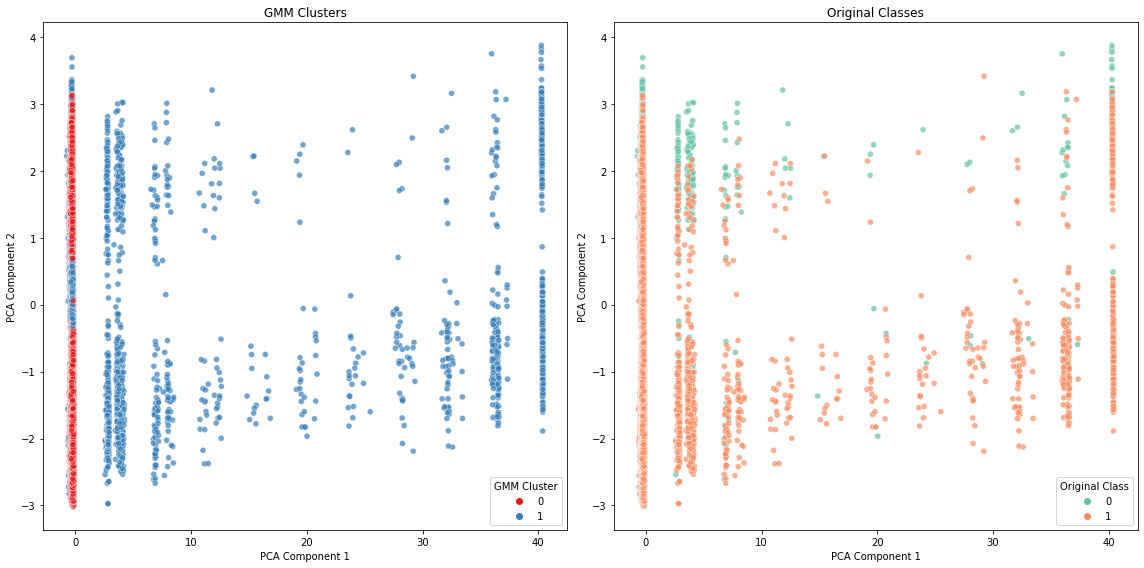

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Perform PCA to reduce the dataset to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Predict clusters using GMM
y_cluster = gmm.predict(X_scaled)

# Create a DataFrame with PCA results, GMM clusters, and original class labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['GMM Cluster'] = y_cluster
pca_df['Original Class'] = y  # Assuming `y_sample` is the original target label

# Plot side-by-side comparison of GMM clusters and original classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot GMM Clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='GMM Cluster', data=pca_df, palette='Set1', ax=ax1, alpha=0.7)
ax1.set_title('GMM Clusters')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.legend(title='GMM Cluster')

# Plot Original Classes
sns.scatterplot(x='PCA1', y='PCA2', hue='Original Class', data=pca_df, palette='Set2', ax=ax2, alpha=0.7)
ax2.set_title('Original Classes')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.legend(title='Original Class')

plt.tight_layout()
plt.show()



In [ ]:
# generate synthetic data to see that it actually works to show gaussians 

# in report -- talk about hetereogeneity and applications of understanding this 
# hetereogeneity (fairness report and everything else)

# need to also talk about the methods within the dataset